In [155]:
## Import methods from
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
%reload_ext autoreload

from collections.abc import Iterable
import matplotlib.pyplot as plt
from itertools import chain
from scipy.linalg import hilbert
from scipy.linalg import hessenberg

QR_ALGORITHM_TOLERANCE = 1e-10 
WILKISON_SHIFT = "wilkinson"

In [290]:
def hessenberg_form(Ac):
    
    '''
    Input:
        A: Matrix to perform schur decomposition A = QTQ*
    Return:
        H: Return a Hessenberg form

    '''
    
    r, m = Ac.shape
    A = np.copy(Ac)

    for k in range(m-2):

        x = A[k+1:m,k]

        e1= np.zeros(len(x)); e1[0] = 1
        vk = np.sign(x[0])*np.linalg.norm(x,2)*e1 + x
        vk = vk/np.linalg.norm(vk,2)


        vkvk = np.outer(vk, vk)

        ## left multiplication of A with householder reflector
        A[k+1:m, k:m] = A[k+1:m, k:m] - (2*vkvk@A[k+1:m,k:m])

        ## right multiplication of A with householder reflector
        A[0:m, k+1:m] = A[0:m, k+1:m] - 2*(A[0:m, k+1:m]@vkvk)

    return A

def householder(A):
    
    '''
    Input: 
        A: matrix to be orthogonalized
        Modifies A internally to create a R upper triangular matrix.
    Return: 
        Q: orthonormal matrix
        R: Upper triangular matrix
        
    '''
    
    r, c = A.shape
    A = np.copy(A)
    Q = np.zeros((r,c))
    
    v = []
    
    for k in range(c):
        
        x = A[k:r,k]
        e1= np.zeros(len(x)); e1[0] = 1
        vk = np.sign(x)*np.linalg.norm(x,2)*e1 + x
        vk = vk/np.linalg.norm(vk,2)
        v.append(vk)
        A[k:r, k:c] = A[k:r, k:c] - (2*np.outer(vk, vk))@A[k:r, k:c]
     
    ## calculating  Q
    
    for i in range(c):
        x = np.zeros(r); x[i] = 1
        for k in reversed(range(0, c)):
            
            vk_ = v[k]
            x[k:r] = x[k:r] - 2*vk_*(vk_.T@x[k:r])
            
        Q[:,i] = x
        
    return Q,A[:c,:c]


def QR_shift(matrix, eps, computed_eigvals, convergence, shift):
    
    """
    
    The QR shift algorithm that finds the eigenvalues recursively, and 
    deflate the matrix when sub-diagonal are less than eps. 
    
    It uses shift. Shift options are as follows;
        
        * miu : Last element in the matrix.
        
        * wilkinson shift
        
    
    Input: 
        matrix: A matrix to do QR on
        eps: epsilon need to break the while loop
        computed_eigvals: list to append eigenvalues when its found.
    
    Ouput: 
        return an eigenvalues recursively
        
    """
    
    A = matrix.copy()
    
    if A.shape[0] == 1 :

        ##appending to eigvals list
        ##  A has converge to an eigenvalues
        
        computed_eigvals.append(A[0].item())
        
        return A[0].item()
    
    while np.abs(np.sum(A[-1,0:-1])) > eps or check_deflation(A, eps)[0]:
        
        ## pick a miu
        ## choose the last element. 
        
        # Use the miu based on the last element of the matrix.
        #mu =  A[-1, -1] 
        # find miu for shift based on wilkinson_shift
        if shift == "wilkinson":
            mu = wilkinson_shift(A)
        else:
            mu =  A[-1, -1] 
            
        ## QR factorization with householder
        Q, R = householder(A - mu*np.eye(A.shape[0]))
        
        ## Recalculate A; 
        
        A = R@Q + mu*np.eye(A.shape[0])
        
        m, n = A.shape
        ## update the last element;
        
        convergence.append(A[m-1,m-2])
        
        ## check deflation and break the matrix.
        b, idx = check_deflation(A, eps)
        
        if idx != None:
            #print(idx, A.shape)
            ## setting (i,i+1), and (i+1, i) to zero
            
            A[idx[0], idx[1]] = 0
            A[idx[1], idx[0]] = 0
            
            ## splitting H to subdiagonals
            A1 = A[0:idx[0]+1, 0:idx[0]+1]
            A2 = A[idx[0]+1:A.shape[0], 
                    idx[0]+1:A.shape[0]]
            
            ## recursively performing QR-shift iteration on A1 and A2
            #return QR_shift(A1, eps), QR_shift(A2, eps)
            
            return QR_shift(A1, eps, computed_eigvals, convergence, WILKISON_SHIFT), \
                    QR_shift(A2, eps, computed_eigvals, convergence, WILKISON_SHIFT)

    return

def pureQR(matrix, eps):
    
    A = matrix.copy()
    
    while np.abs(np.sum(A[-1,0:-1])) > eps:
        
        ## pick a miu
        ## choose the last element. 
        
        mu =  A[-1, -1] 
        
        ## QR factorization with householder
        Q, R = householder(A)
        
        ## Recalculate A; 
        
        A = R@Q
        
    return A

def check_deflation(A, eps):
    ##  check the sub-diagonals < eps
    ## return sub-diagonals index
    
    for i in range(A.shape[0]-1):
        if abs(A[i+1, i]) < eps: 
            return (True, (i, i+1))
    return (False, None)


## wilkinson shift;

def wilkinson_shift(A):
    
    m,n = A.shape
    B = A[m-2:m, m-2:m]
    rho = (B[0, 0] -  B[1, 1])/2
    
    return B[1, 1] - np.sign(rho)*B[0, 1]**2/(np.abs(rho) + np.sqrt(rho**2 + B[0, 1]**2))
        

## testing matrices

def uniform_symetric(n):
    np.random.seed(0)
    U = np.random.uniform(low=0, high=1.0, size=(n, n))
    S = np.tril(U) + np.tril(U, -1).T
    
    return S

def hilbert_matrix(n):
    
    return hilbert(n)

def test_matrix(p, q, n):
    
    h = np.pi/n
    a = -p/(h**2)
    b = (2*p)/h**2 + q
    A = np.zeros((n,n))
    
    A[0, 0] = b
    A[0, 1] = a
    A[-1, -2] = 2*a
    A[-1, -1] =b
    
    for i in range(1, n -1):
        
        A[i, i -1: i+2] = [a, b, a]
        
    return A


class hessenTestCase: 

    def __init__(self, testMatrix = None):

        self.testMatrix = testMatrix

    def compare_inbuilt(self):
        
        impl_output = hessenberg(self.testMatrix)
        inb_output = hessenberg_form(self.testMatrix)
        diffl2norm = np.linalg.norm(impl_output - inb_output, 'fro')
        
        return diffl2norm
    
    def compare_bound(self, tol):
        l2diff =  self.compare_inbuilt()
        if l2diff < tol:
            print(f'Calculated hessenberg form is of order {tol} lower')
        else:
           print(f'Comparision difference {l2diff}')

## Hessenberg Form Matrix

In [291]:
## Calculating different matrix for computing hessenberg form

## test matrix
A = np.array([[1,2,3,4], [5,6,7,8], [9, 8, 7, 6], [5,4, 3, 2]], dtype = float)
#print(hessen(A))
A0=hessenberg_form(A)

In [292]:
## comparing the hessen output with implemented algorithm
testcase = hessenTestCase(A)
testcase.compare_bound(1*10**-10)

Calculated hessenberg form is of order 1e-10 lower


In [294]:
# hilbert matrix
testcase = hessenTestCase(hilbert_matrix(100))
testcase.compare_bound(1*10**-10)

Calculated hessenberg form is of order 1e-10 lower


### Find eigenvalues for different matrices

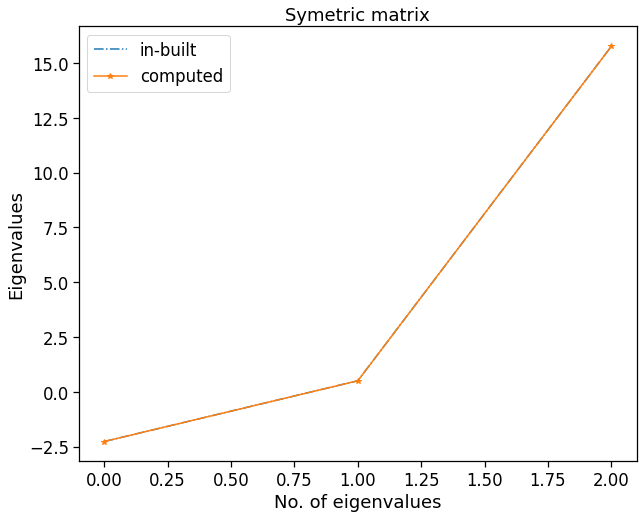

In [276]:
A = np.array([[1,2,4], [2,6,8], [4, 8, 7]], dtype = float)
A0 = (A)

inbuilt_eigvals = np.array(sorted(np.linalg.eigvals(A)))
convergence = []
computed_eigvals = []
QR_shift(A0, QR_ALGORITHM_TOLERANCE, computed_eigvals, convergence, WILKISON_SHIFT)
computed_eigvals = np.array(sorted(computed_eigvals))   

plt.plot(range(len(inbuilt_eigvals)), inbuilt_eigvals, '-.', label = "in-built")
plt.plot(range(len(computed_eigvals)), computed_eigvals, '-*', label = "computed")

plt.xlabel("No. of eigenvalues")
plt.ylabel("Eigenvalues")
plt.title("Symetric matrix")
plt.legend()

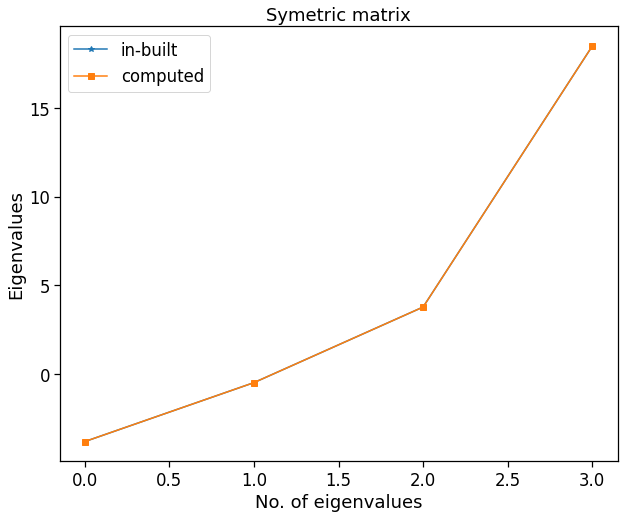

In [278]:
A = np.array([[1,2,4,5], 
              [2,6,8, 4], 
              [4, 8, 7, 3], 
              [5, 4, 3, 4]
             ], dtype = float)

convergence = []
computed_eigvals = []
A0 = hessenberg_form(A)

QR_shift(A0, QR_ALGORITHM_TOLERANCE , computed_eigvals, convergence, WILKISON_SHIFT)
computed_eigvals = np.array(sorted(np.array(computed_eigvals)))
inbuilt_eigvals =sorted(np.linalg.eigvals(A))

plt.plot(range(len(inbuilt_eigvals)), inbuilt_eigvals, '-*', label = "in-built")
plt.plot(range(len(computed_eigvals)), computed_eigvals,'-s', label = "computed")
plt.xlabel("No. of eigenvalues")
plt.ylabel("Eigenvalues")
plt.title("Symetric matrix")
plt.legend()

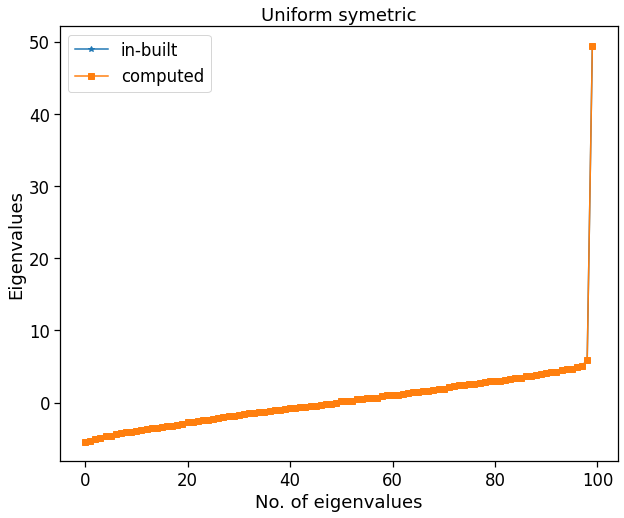

In [280]:
n = 100
S = uniform_symetric(n)
A0 = hessenberg_form(S)

computed_eigvals = []
convergence = []
QR_shift(A0, QR_ALGORITHM_TOLERANCE , computed_eigvals, convergence, WILKISON_SHIFT)
computed_eigvals = np.array(sorted(np.array(computed_eigvals)))
inbuilt_eigvals =sorted(np.linalg.eigvals(S))
plt.plot(range(len(inbuilt_eigvals)), inbuilt_eigvals, '-*',label = "in-built")
plt.plot(range(len(computed_eigvals)), computed_eigvals,'-s', label = "computed")
plt.xlabel("No. of eigenvalues")
plt.ylabel("Eigenvalues")
plt.title("Uniform symetric")
plt.legend()

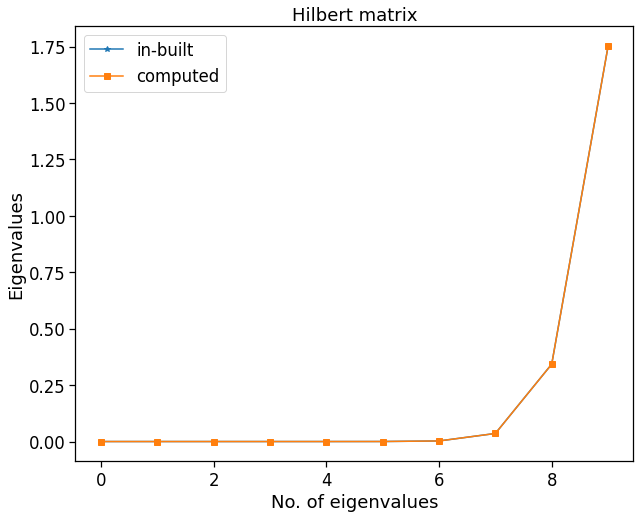

In [281]:
n = 10
hil = hilbert_matrix(n)
A0 = hessenberg_form(hil)

computed_eigvals = []
convergence = []
QR_shift(A0, QR_ALGORITHM_TOLERANCE , computed_eigvals, convergence, WILKISON_SHIFT)
computed_eigvals = np.array(sorted(np.array(computed_eigvals)))
inbuilt_eigvals =sorted(np.linalg.eigvals(hil))
plt.plot(range(len(inbuilt_eigvals)), inbuilt_eigvals, '-*',label = "in-built")
plt.plot(range(len(computed_eigvals)), computed_eigvals,'-s', label = "computed")
plt.xlabel("No. of eigenvalues")
plt.ylabel("Eigenvalues")
plt.title("Hilbert matrix")
plt.legend()

In [288]:
matrix_size = [5, 35, 50, 65, 90 ,100]

error_array = []
for n in matrix_size:  

    #hil = hilbert_matrix(n)
    hil = uniform_symetric(n)
    A0 = hessenberg_form(hil)

    computed_eigvals = []
    convergence = []
    
    QR_shift(A0, QR_ALGORITHM_TOLERANCE , computed_eigvals, convergence, "NotSpecified")
    computed_eigvals = np.array(sorted(np.array(computed_eigvals)))
    inbuilt_eigvals =sorted(np.linalg.eigvals(hil))
    
    error_array.append(np.linalg.norm(computed_eigvals - inbuilt_eigvals, 2))

Text(0.5, 1.0, 'QR with shift as last element')

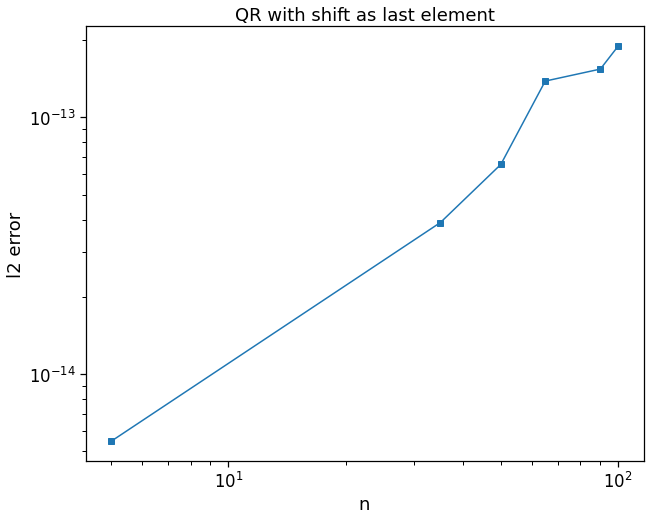

In [289]:
plt.loglog(matrix_size, error_array, "-s")
plt.xlabel("n")
plt.ylabel("l2 error")
plt.title("QR with shift as last element")

In [286]:
error_array = []
for n in matrix_size:  

    #hil = hilbert_matrix(n)
    hil = uniform_symetric(n)
    A0 = hessenberg_form(hil)

    computed_eigvals = []
    convergence = []
    
    QR_shift(A0, QR_ALGORITHM_TOLERANCE , computed_eigvals, convergence, WILKISON_SHIFT)
    computed_eigvals = np.array(sorted(np.array(computed_eigvals)))
    inbuilt_eigvals =sorted(np.linalg.eigvals(hil))
    
    error_array.append(np.linalg.norm(computed_eigvals - inbuilt_eigvals, 2))

Text(0.5, 1.0, 'QR with wilkinson shift')

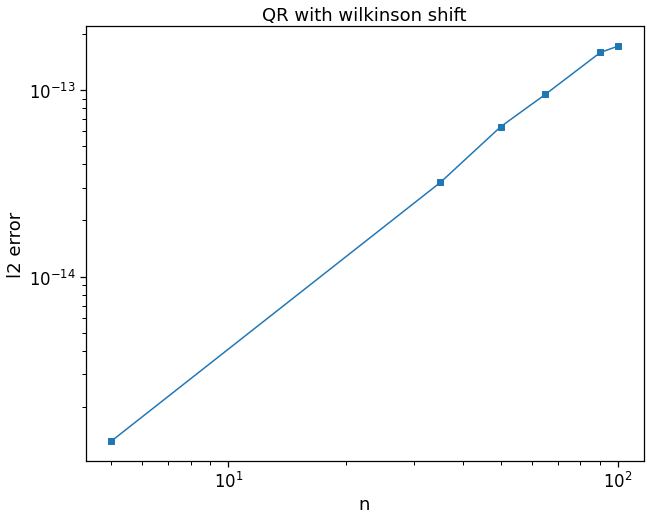

In [287]:
plt.loglog(matrix_size, error_array, "-s")
plt.xlabel("n")
plt.ylabel("l2 error")
plt.title("QR with wilkinson shift")

In [251]:
error_array = []
for n in matrix_size:  
    
    #hil = hilbert_matrix(n)
    hil = uniform_symetric(n)
    A0 = hessenberg_form(hil)
    
    computed_eigvals = np.array(sorted(np.diag(pureQR(A0, QR_ALGORITHM_TOLERANCE))))
    inbuilt_eigvals = np.array(sorted(np.linalg.eigvals(hil)))
    error_array.append(np.linalg.norm(computed_eigvals - inbuilt_eigvals, 2))

Text(0.5, 1.0, 'pure QR l2 error')

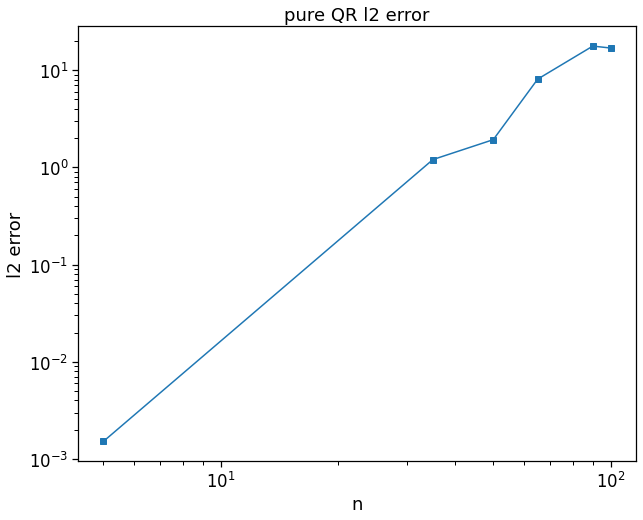

In [256]:
plt.loglog(matrix_size, error_array, "-s")
plt.xlabel("n")
plt.ylabel("l2 error")
plt.title("pure Q")